In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [26]:
import torch
import tsensor
import math
from IPython.display import Markdown as md
import plotly.express as px
import numpy as np
import pandas as pd

In [3]:
from itertools import cycle
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=1.0,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

Let's make a few assumptions and set a few variables upfront

In [4]:
embedding_dim = 512
attn_dim = 64
seq_len = 10

## Embedding Representation of a Sentence

So after embedding a sentence(which is a collection of _seq_len_ words) can be represented as a matrix of (_seq_len_x_embedding_dim_)

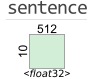

In [5]:
sentence = torch.randn(seq_len, embedding_dim)
with tsensor.explain(fontsize=20, dimfontsize=12):
    sentence

# Self Attention

Let's first see how Scaled Dot Product Attention can be calculated for all the word-pairs in a sentence. We also call this self-attention where query, key and value are the same.

----------
### Step 1: Define three learnable matrices, one each for query, key and value

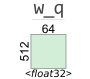

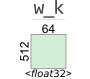

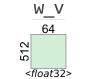

In [6]:
w_q = torch.randn(embedding_dim, attn_dim)
w_k = torch.randn(embedding_dim, attn_dim)
w_v = torch.randn(embedding_dim, attn_dim)
with tsensor.explain(fontsize=20, dimfontsize=12):
    w_q
    w_k
    w_v

----------
### Step 2: Convert input embeding into attention dimensions using W_q, W_k, W_v

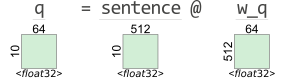

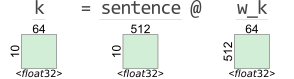

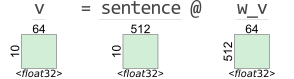

In [7]:
with tsensor.explain(fontsize=20, dimfontsize=12):
    q = sentence @ w_q
    k = sentence @ w_k
    v = sentence @ w_v

-----------------
### Step 3 - Calculate the attention weights between all the query and value pairs

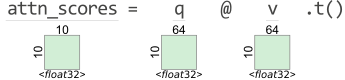

In [8]:
scaling = 1/math.sqrt(attn_dim)
with tsensor.explain(fontsize=20, dimfontsize=12):
    attn_scores = q @ v.t()
attn_weights = torch.softmax(attn_scores/scaling, dim=-1)

------
### Step 4 - Use the attention weights to combine the values

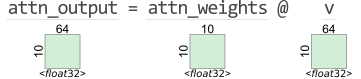

In [9]:
with tsensor.explain(fontsize=20, dimfontsize=12):
    attn_output = attn_weights @ v

------
### Putting it all together

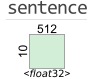

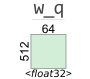

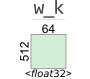

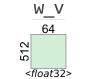

In [10]:
with tsensor.explain(fontsize=20, dimfontsize=12):
    sentence
    w_q
    w_k
    w_v

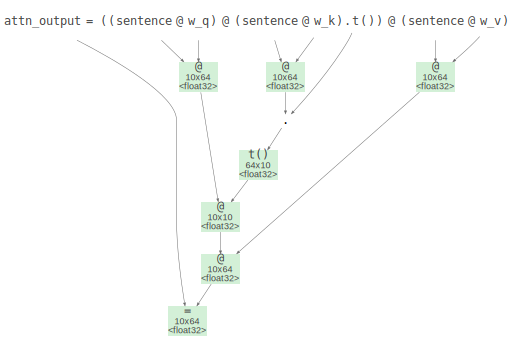

In [11]:
tsensor.astviz("attn_output = ((sentence @ w_q) @ (sentence @ w_k).t()) @ (sentence @ w_v)")

--------
# Multi-headed Self Attention    

We saw how we calculate attention using query, key and values using matrix multiplication. Now let's see how we can extend this to multiple attention heads, but still be efficient by utilizing matrix multiplcations and not calculating each head separately

In [12]:
n_heads = 8

----------
### Step 1: Define three learnable matrices, one each for query, key and value

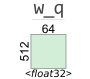

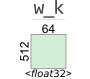

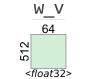

In [13]:
w_q = torch.randn(embedding_dim, attn_dim)
w_k = torch.randn(embedding_dim, attn_dim)
w_v = torch.randn(embedding_dim, attn_dim)
with tsensor.explain(fontsize=20, dimfontsize=12):
    w_q
    w_k
    w_v

----------
### Step 2: Convert input embeding into attention dimensions using W_q, W_k, W_v

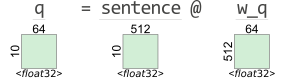

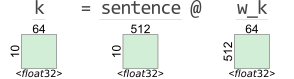

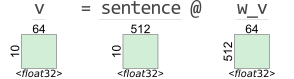

In [14]:
with tsensor.explain(fontsize=20, dimfontsize=12):
    q = sentence @ w_q
    k = sentence @ w_k
    v = sentence @ w_v

----------
### Step 3: Reshape q, k and v into sub_dim for each head in the multi-headed attention


We reshape q, k, and v so that we can use efficient matrix multiplication to process all the heads together. We do it by splitting the q, k and v into sub dimensions over which each attention head works.

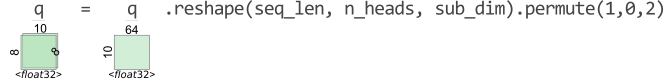


-----
### q, k, v dimensions: n_heads, seq_len, sub_dim : 8 x 10 x 8


In [15]:
sub_dim = attn_dim//n_heads
with tsensor.explain(fontsize=20, dimfontsize=12):
    q = q.reshape(seq_len, n_heads, sub_dim).permute(1,0,2)
shape_str = " x ".join([str(i) for i in q.size()])
display(md(f"""
-----
### q, k, v dimensions: n_heads, seq_len, sub_dim : {shape_str}
"""))
#Similar transformation to k and v
k = k.reshape(seq_len, n_heads, sub_dim).permute(1,0,2)
v = v.reshape(seq_len, n_heads, sub_dim).permute(1,0,2)

-----------------
### Step 4 - Calculate the attention weights between all the query and value pairs for each head

We calculate the attention weights for each head separately, but through a single matrix operation

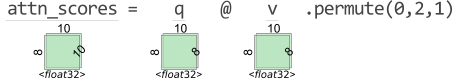

In [16]:
scaling = 1/math.sqrt(attn_dim)
with tsensor.explain(fontsize=20, dimfontsize=12):
    attn_scores = q @ v.permute(0,2,1)
attn_weights = torch.softmax(attn_scores/scaling, dim=-1)

------
### Step 5 - Use the attention weights to combine the values for each head

Now that we have the attention weight for each head, we apply those weights to the corresponding value splits

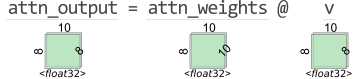


-----
### attn_output dimensions: n_heads, seq_len, sub_dim : 8 x 10 x 8


In [17]:
with tsensor.explain(fontsize=20, dimfontsize=12):
    attn_output = attn_weights @ v
    
shape_str = " x ".join([str(i) for i in attn_output.size()])
display(md(f"""
-----
### attn_output dimensions: n_heads, seq_len, sub_dim : {shape_str}
"""))

------
### Step 6 - Reshape and combine the attn_output of each head into a single dimension

And finally, we reshape the tensor and combine all the attention outputs from each head into a single dimension

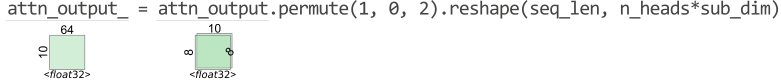


-----
### attn_output dimensions: seq_len, n_heads*sub_dim (attn_dim) : 8 x 10 x 8


In [18]:
with tsensor.explain(fontsize=20, dimfontsize=12):
    attn_output_ = attn_output.permute(1, 0, 2).reshape(seq_len, n_heads*sub_dim)
shape_str = " x ".join([str(i) for i in attn_output.size()])
display(md(f"""
-----
### attn_output dimensions: seq_len, n_heads*sub_dim (attn_dim) : {shape_str}
"""))

# Positional Encoding

$ \Large p_{i,2j} = sin\left (\frac{i}{10000^{\frac{2j}{d}}} \right)$


$ \Large p_{i,2j+1} = cos\left (\frac{i}{10000^{\frac{2j}{d}}} \right)$

In [73]:
import math
seq_len = 50
embedding_dim = 256

Let's calculate the P vector using loops

In [74]:
# Initializing a tensor to store P
P_loop = torch.zeros((seq_len, embedding_dim))

#Loop over sequence length
for pos in range(seq_len):
    # Loop over embedding dim
    for i in range(embedding_dim//2):
        P_loop[pos, 2*i] = math.sin(pos/10000**(2*i/embedding_dim))
        P_loop[pos, (2*i)+1] = math.cos(pos/10000**(2*i/embedding_dim))

Although the previous implementation is easier to understand, vectorizing the operation will lead to more performant code

In [75]:
P_vec = torch.zeros((seq_len, embedding_dim))
# Calculating the numerator
numerator = torch.arange(seq_len, dtype=torch.float32).reshape(-1, 1)
# Calculating the exponent term in the denominator
denominator_exponent = torch.arange(
            0, embedding_dim, 2, dtype=torch.float32) / embedding_dim
# Calculating the denominator
denominator = torch.pow(10000, denominator_exponent)
# Calculating the term in the brackets
X = numerator/denominator

# Selecting even positions and filling it with sin(x)
P_vec[:, 0::2] = torch.sin(X)
# Selecting odd positions and filling it with sin(x)
P_vec[:, 1::2] = torch.cos(X)

In [79]:
P_vec[:, 250]

tensor([0.0000, 0.0001, 0.0002, 0.0004, 0.0005, 0.0006, 0.0007, 0.0009, 0.0010,
        0.0011, 0.0012, 0.0014, 0.0015, 0.0016, 0.0017, 0.0019, 0.0020, 0.0021,
        0.0022, 0.0024, 0.0025, 0.0026, 0.0027, 0.0029, 0.0030, 0.0031, 0.0032,
        0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0040, 0.0041, 0.0042, 0.0043,
        0.0045, 0.0046, 0.0047, 0.0048, 0.0050, 0.0051, 0.0052, 0.0053, 0.0055,
        0.0056, 0.0057, 0.0058, 0.0060, 0.0061])

In [35]:
torch.allclose(P_loop, P_vec, atol=1e-5)

True

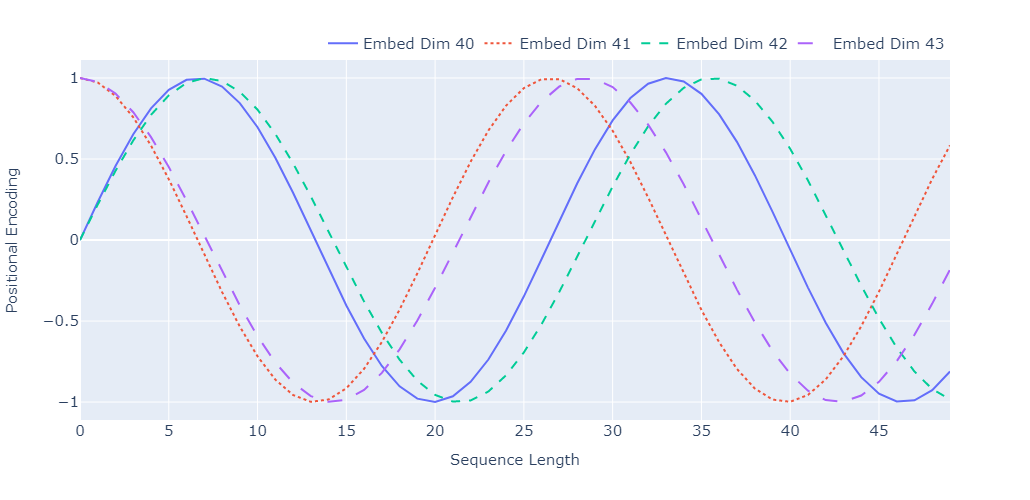

In [105]:
plot_dict = {"Sequence Length":np.arange(seq_len)}
for i, r in enumerate(P_vec[:, 40:44].T.numpy()):
    plot_dict[f"Embed Dim {i+40}"] = r
plot_df = pd.DataFrame(plot_dict)
plot_df = pd.melt(plot_df, id_vars = "Sequence Length", var_name="Embedding", value_name="Positional Encoding")

# Visualizing a subset of the hidden dimensions across different positions
fig = px.line(plot_df, x="Sequence Length", y="Positional Encoding", color="Embedding", line_dash="Embedding")
fig = format_plot(fig, xlabel="Sequence Length", ylabel="Positional Encoding")
fig.write_image(f"imgs/chapter_13/pos_encoding.png")
fig.show()

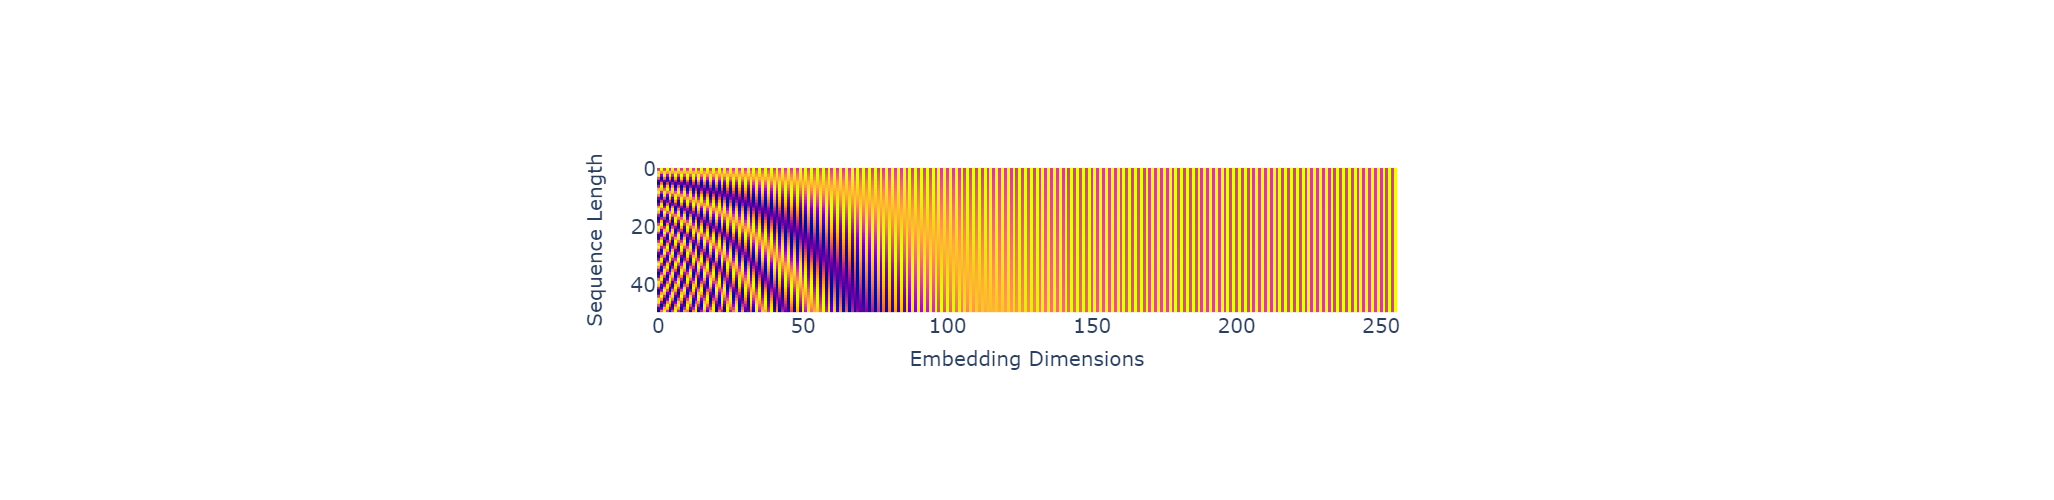

In [88]:
# Visualizing a subset of the hidden dimensions across different positions
fig = px.imshow(P_vec, width=900, height=500)
fig = format_plot(fig, xlabel="Embedding Dimensions", ylabel="Sequence Length", font_size=20)
fig.update_coloraxes(showscale=False)
fig.write_image(f"imgs/chapter_13/pos_encoding_heatmap_full.png")
fig.show()

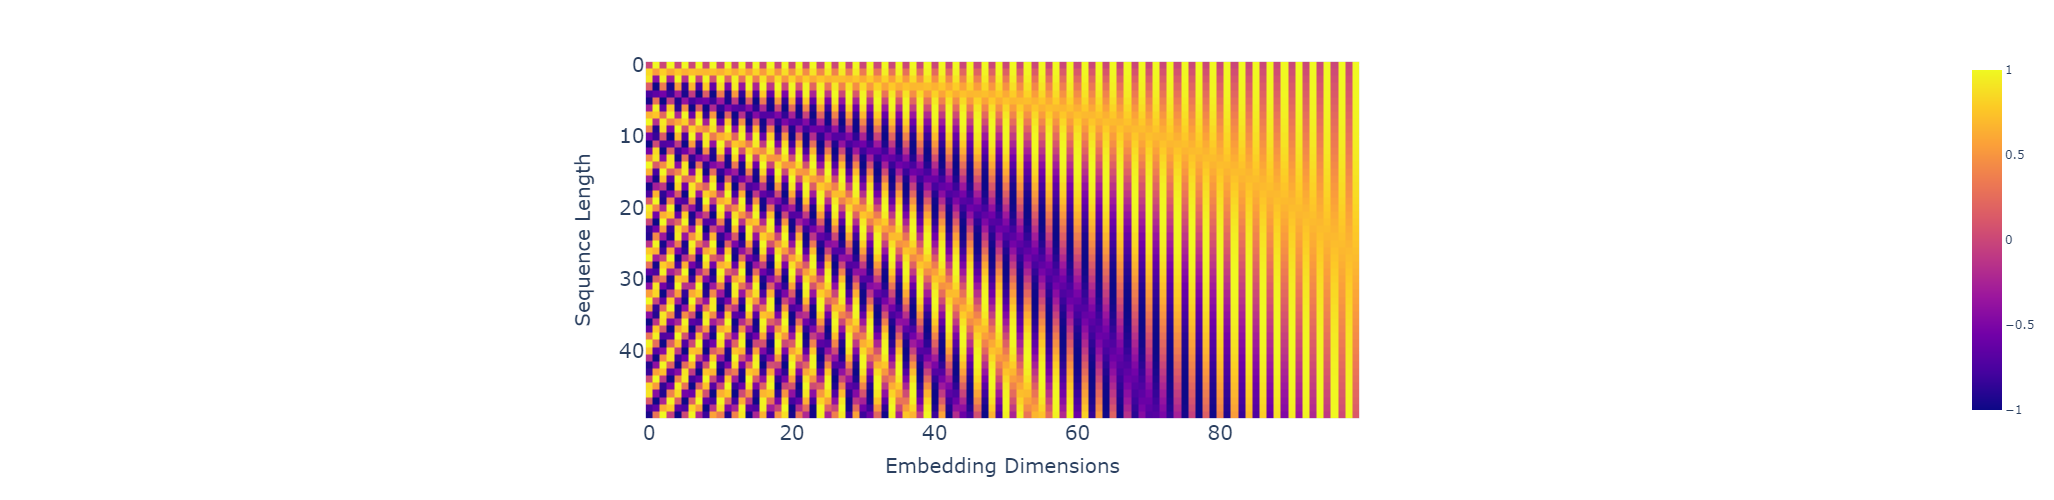

In [89]:
# Visualizing a subset of the hidden dimensions across different positions
fig = px.imshow(P_vec[:,:100], width=900, height=500)
fig = format_plot(fig, xlabel="Embedding Dimensions", ylabel="Sequence Length", font_size=20)
# fig.update_coloraxes(showscale=False)
fig.write_image(f"imgs/chapter_13/pos_encoding_heatmap_part.png")
fig.show()

In [321]:
import plotly.graph_objs as go
def plot_vector_position_encoding(vector_point, pos_encoded_vector_points, title="", width=600, height=600, font_size=15, xaxis_range = [-1,1], yaxis_range=[-1,1]):
    layout1= go.Layout(title=go.layout.Title(text="",x=0.5),
            xaxis={'title':'x', 'range':xaxis_range},
            yaxis={'title':'y','range':yaxis_range})
    point_plots = []
    for (x,y) in vector_point:
        point_plot=[
          go.Scatter(x=[x],
                     y=[y],
                     name="Original",
                     mode='markers',
                     marker_size=10,
                     marker_symbol="x"
                    ),
        ]
        point_plots += point_plot
    showlegend = True
    for i, (x,y) in enumerate(pos_encoded_vector_points):
        point_plot=[
          go.Scatter(x=[x],
                     y=[y],
                     name="Position Encoded",
                     mode='markers+text',
                     marker_symbol="star",
                     marker_size=8,
                     text=i,
                     textposition='middle right',
                     textfont={"size":15},
                     showlegend=showlegend
                    ),
        ]
        showlegend = False
        point_plots += point_plot
    fig = go.Figure(data=point_plots, layout=layout1)
    for (x, y) in vector_point:
        fig.add_annotation(
            x=x,
            y=y,
            ax=0,
            ay=0,
            xref="x",
            yref="y",
            axref="x",
            ayref="y",
            text="",  # if you want only the arrow
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
        )
    fig.update_layout(
        autosize=False,
        width=width,
        height=height,
        title_text="",
        titlefont={"size": 20},
        legend_title=None,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        yaxis=dict(
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig

In [331]:
seq_len = 20
A = torch.tensor([1.5654, 0.7104]).unsqueeze(0).repeat(seq_len, 1)

In [332]:
# Initializing a tensor to store P
P_loop = torch.zeros((A.size(0), 2))

#Loop over sequence length
for pos in range(A.size(0)):
    # Loop over embedding dim
    for i in range(2//2):
        P_loop[pos, 2*i] = math.sin(pos/10000**(2*i/2))
        P_loop[pos, (2*i)+1] = math.cos(pos/10000**(2*i/2))

In [333]:
A_pos = A + P_loop

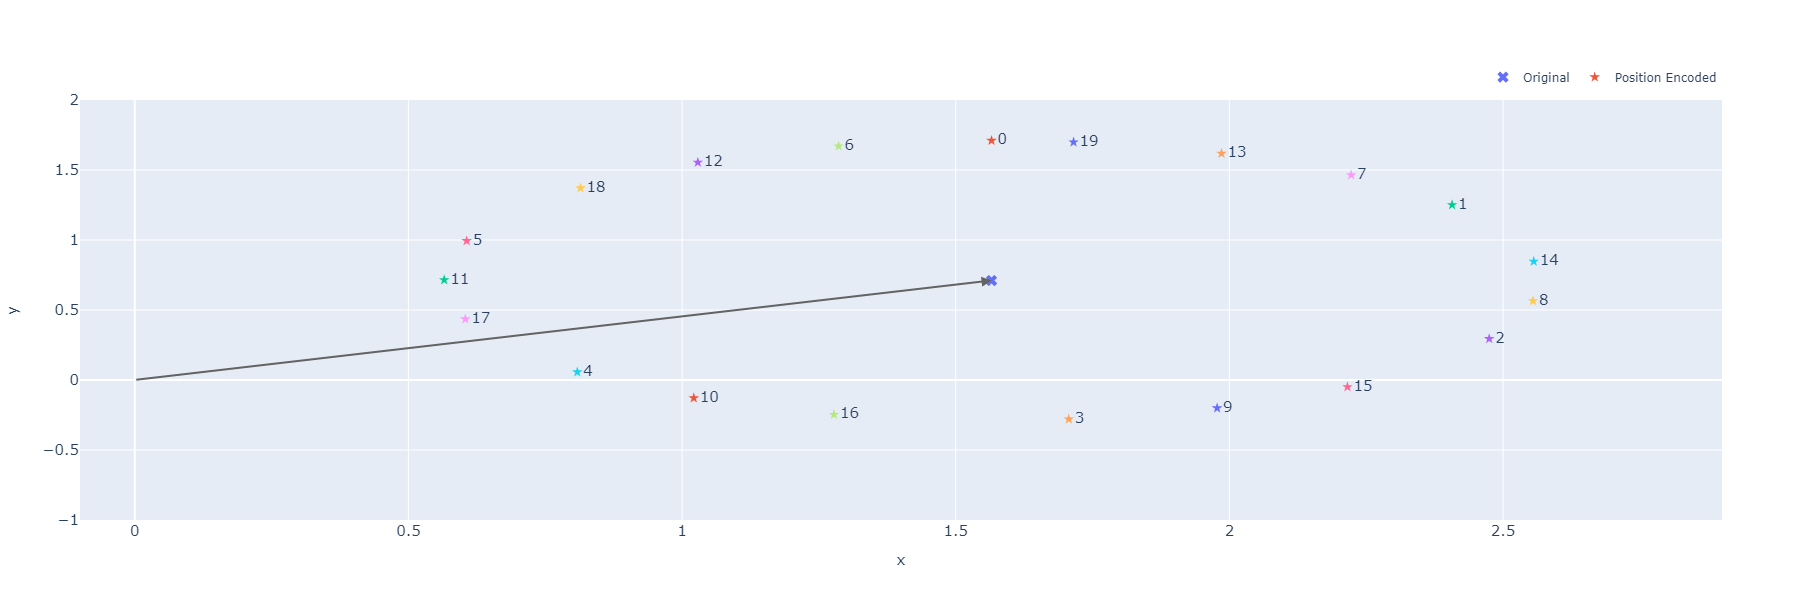

In [335]:
fig = plot_vector_position_encoding(A[0:1,:], A_pos, xaxis_range=[-0.1,2.9], yaxis_range=[-1,2])
fig.write_image(f"imgs/chapter_13/pos_encoding_intuition.png")
fig.show()

In [136]:
plot_vector_points([A, A_pos], names=["A", "A_pos"], axis_range=[0,6])

ValueError: not enough values to unpack (expected 2, got 1)

In [133]:
plot_vector_points([A.numpy(), A_pos.numpy()], names=["A", "A_pos"], axis_range=[0,6])

ValueError: not enough values to unpack (expected 2, got 1)